In [1]:
#import pairs_backtest as pb
import talib 
import numpy as np
import datetime as dt #in-built module
import pandas as pd
from pandas_datareader import data
import yfinance as yf
from yahoo_fin import stock_info as si
import matplotlib.pyplot as plt
from matplotlib import style
from pathlib import Path
import os
from tqdm import tqdm   
from pairs_backtest import kalman_lib as kalman
from pairs_backtest import find_pairs
from pairs_backtest import utils
from pandas_datareader import data as pdr
import statsmodels.tsa.stattools as ts 
import seaborn as sns
import statsmodels.api as sm

In [2]:
def get_data(code,start,end):
    data = yf.Ticker(code)
    data = data.history(start = start, end = end)
    #data.index = data.index.strftime('%d/%m/%Y')
    return data

In [3]:
pairs = pd.read_csv('pairs_2024_1_15.csv')


In [4]:
date = dt.datetime.now()
date ='%s_%s_%s'%(date.year,date.month,date.day)
backtest_day = 730
start = dt.datetime.now()- dt.timedelta(days=backtest_day)
#end = dt.datetime.now()
#start = pd.Timestamp('2012-01-01')
#end = pd.Timestamp('2020-03-05')
end = dt.date.today()


In [5]:
combin_df_index = get_data('SPY',start,end).index
combin_df_index

DatetimeIndex(['2022-02-08 00:00:00-05:00', '2022-02-09 00:00:00-05:00',
               '2022-02-10 00:00:00-05:00', '2022-02-11 00:00:00-05:00',
               '2022-02-14 00:00:00-05:00', '2022-02-15 00:00:00-05:00',
               '2022-02-16 00:00:00-05:00', '2022-02-17 00:00:00-05:00',
               '2022-02-18 00:00:00-05:00', '2022-02-22 00:00:00-05:00',
               ...
               '2024-01-24 00:00:00-05:00', '2024-01-25 00:00:00-05:00',
               '2024-01-26 00:00:00-05:00', '2024-01-29 00:00:00-05:00',
               '2024-01-30 00:00:00-05:00', '2024-01-31 00:00:00-05:00',
               '2024-02-01 00:00:00-05:00', '2024-02-02 00:00:00-05:00',
               '2024-02-05 00:00:00-05:00', '2024-02-06 00:00:00-05:00'],
              dtype='datetime64[ns, America/New_York]', name='Date', length=501, freq=None)

In [6]:
def check_if_have_signal(df):
  unique_value = set(df.numUnits.unique())
  return unique_value

if not os.path.exists('for_testing'):
  os.makedirs('for_testing')
#first_inst = 'GDX'
#second_inst = 'JPM'
combin_df = pd.DataFrame(index = combin_df_index)
pair_score = []

for pair in pairs.iterrows():
  x_df = get_data(pair[1]['s1'],start,end)
  y_df = get_data(pair[1]['s2'],start,end)
  common_index = (x_df.index).intersection(y_df.index)
  x_df = x_df.loc[common_index].copy()
  y_df = y_df.loc[common_index].copy()
  df, sharpe, _ = kalman.backtest(x_df.Close, y_df.Close) #df1 = x; df2 = y
  df = df.iloc[:-1,:]


  half_life = kalman.half_life(df['spread'])

  unique_signal = check_if_have_signal(df)

  result = ts.coint(((x_df['Close'])),(y_df['Close']))
  score = result[0]
  pvalue = result[1]
  #print('Score:', score)
  #print('pvalue:', pvalue)

  adf = kalman.adf_test(df)
  #print(adf)
  if np.isnan(sharpe) or ( unique_signal == {np.nan, 0} or (len(df) < 365 )) :
    print('pass because of sharpe ratio with Nan / No any signals generated/ too short')
    continue

  name_of_pair = pair[1]['s1'] + '_' + pair[1]['s2']
  pair_score.append([name_of_pair,score,pvalue, len(df),adf, df.iloc[-1]['cum rets'],unique_signal])
  df_pair_score = pd.DataFrame(pair_score, columns=['pairs','coint score','coint p-value','len','adf p-value','final_cum_rets','signal'])
  
  #df = df.dropna()
  df.to_csv('for_testing/%s.csv'%(name_of_pair))
  print ('%s vs %s has sharp ratio of %0.2f' %(pair[1]['s1'],pair[1]['s2'],sharpe))
  
  df['cum rets'] = df['cum rets'].fillna(1)

  #combin_df[pair[1]['s1']+'_'+pair[1]['s2']+'cum rets'] = df['cum rets'].fillna(1).copy()
  df.rename(columns={"cum rets": name_of_pair+'_'+'cum rets'}, inplace = True)
  combin_df = pd.concat([combin_df,df[name_of_pair+ '_'+'cum rets']],axis = 1)


pass because of sharpe ratio with Nan / No any signals generated/ too short
pass because of sharpe ratio with Nan / No any signals generated/ too short
pass because of sharpe ratio with Nan / No any signals generated/ too short
pass because of sharpe ratio with Nan / No any signals generated/ too short
pass because of sharpe ratio with Nan / No any signals generated/ too short
pass because of sharpe ratio with Nan / No any signals generated/ too short
pass because of sharpe ratio with Nan / No any signals generated/ too short
pass because of sharpe ratio with Nan / No any signals generated/ too short
CEG vs JBL has sharp ratio of 2.74
pass because of sharpe ratio with Nan / No any signals generated/ too short
pass because of sharpe ratio with Nan / No any signals generated/ too short
pass because of sharpe ratio with Nan / No any signals generated/ too short
CEG vs JBHT has sharp ratio of 1.97
CEG vs J has sharp ratio of 2.09
pass because of sharpe ratio with Nan / No any signals gener

In [7]:
combin_df

,CEG_JBL_cum rets,CEG_JBHT_cum rets,CEG_J_cum rets,CEG_JCI_cum rets,CEG_K_cum rets,CEG_JPM_cum rets,CEG_JNJ_cum rets,CEG_JKHY_cum rets,CEG_JNPR_cum rets,CEG_IP_cum rets,...,HUM_SWK_cum rets,ADSK_UBER_cum rets,CHRW_EVRG_cum rets,ADSK_APH_cum rets,PGR_WHR_cum rets,ECL_META_cum rets,ADSK_IT_cum rets,TER_XRAY_cum rets,FICO_IR_cum rets,MCHP_OTIS_cum rets
Date,,,,,,,,,,,,,,,,,,,,,
2022-02-08 00:00:00-05:00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2022-02-09 00:00:00-05:00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2022-02-10 00:00:00-05:00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2022-02-11 00:00:00-05:00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2022-02-14 00:00:00-05:00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-31 00:00:00-05:00,1.717254,1.474037,1.477646,1.414126,1.490012,1.396271,1.515081,1.671347,1.541575,1.420128,...,1.766779,1.700596,1.566595,1.576631,1.608108,1.368100,1.474559,1.736908,1.759088,1.443828
2024-02-01 00:00:00-05:00,1.719426,1.456626,1.465533,1.408202,1.478107,1.374720,1.494744,1.654926,1.541575,1.383423,...,1.774285,1.700596,1.566595,1.576631,1.618522,1.368139,1.474559,1.733962,1.764632,1.441627
2024-02-02 00:00:00-05:00,1.713149,1.466902,1.464902,1.408738,1.469056,1.372575,1.486291,1.648392,1.541575,1.371099,...,1.774285,1.700596,1.586824,1.576631,1.612695,1.283659,1.474559,1.750143,1.760297,1.428668


In [8]:
#concatenate together the individual equity curves into a single DataFrame
results_df = combin_df.dropna(axis=1)
#results_df = combin_df.fillna(1)

#equally weight each equity curve by dividing each by the number of pairs held in the DataFrame
results_df /= len(results_df.columns)
print('num of pairs:',len(results_df.columns))

#sum up the equally weighted equity curves to get our final equity curve
final_res = results_df.sum(axis=1)

# square root of sample size for correct number of bins for returns distribution
print('Bin Count =', np.sqrt(len(final_res)))

num of pairs: 437
Bin Count = 22.38302928559939


Text(0, 0.5, 'Returns')

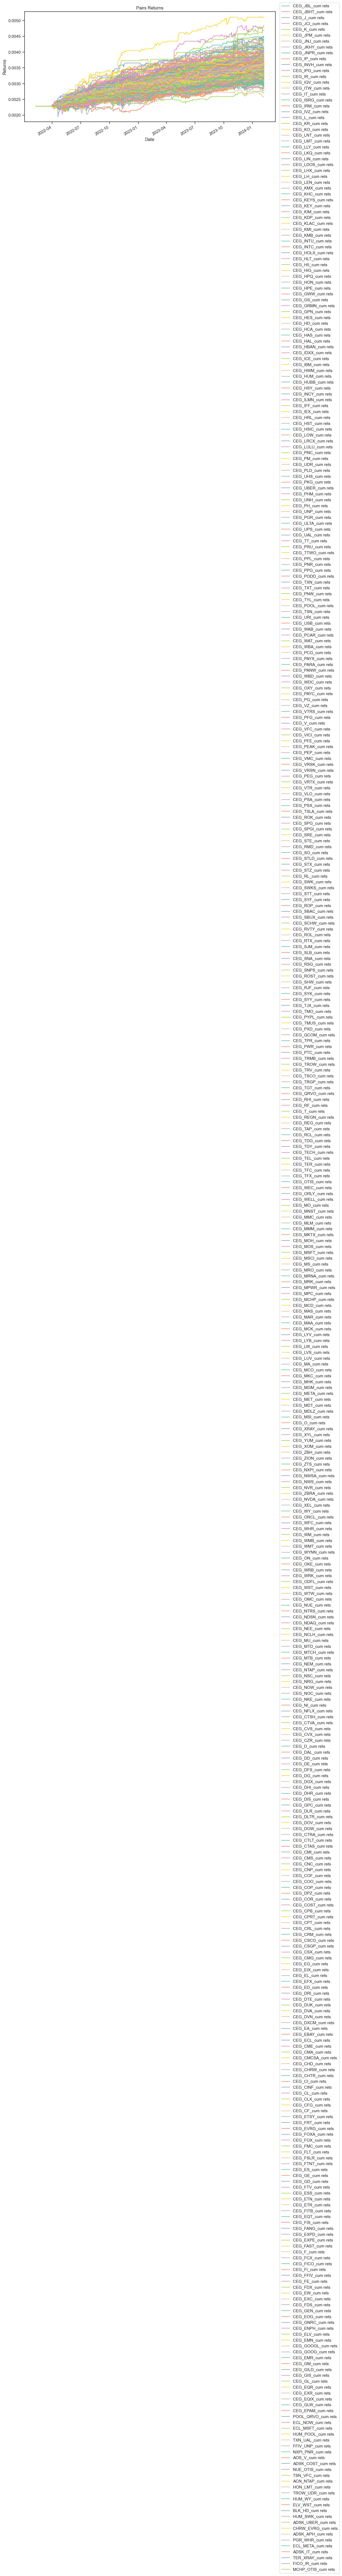

In [9]:
results_df.plot(figsize=(12,6),legend=True)
plt.legend(bbox_to_anchor=(1.01, 1.1), loc='upper left', ncol=1)
#plt.grid(b=None, which=u'major', axis=u'both')
plt.title('Pairs Returns')
plt.xlabel('Date')
plt.ylabel('Returns')

In [10]:
combin_df.dropna(axis=1).shape

(501, 437)

In [11]:
import ffn
Pair_Rets = ffn.to_returns(final_res)
Pair_Rets = pd.DataFrame(Pair_Rets)
Pair_Rets = Pair_Rets.fillna(0)
Pair_Rets.columns = ['Pairs_Returns']

In [12]:
perf = final_res.calc_stats()

In [13]:
num_pairs = len(results_df.columns)
print('Number of Pairs =', num_pairs)

Number of Pairs = 437


In [14]:
bench = get_data('SPY',start,end)['Close'].pct_change().dropna()

In [15]:
Pair_Rets0 = Pair_Rets.loc[str(bench.index[0]):str(bench.index[-1])]

h:\anaconda\envs\backtest\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(
h:\anaconda\envs\backtest\lib\site-packages\pyfolio\timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()


Start date,2022-02-09
End date,2024-02-06
Total months,23
,Backtest
Annual return,23.065%
Cumulative returns,50.953%
Annual volatility,5.788%
Sharpe ratio,3.62
Calmar ratio,9.41
Stability,0.97
Max drawdown,-2.452%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,2.45,2023-11-27,2023-12-07,2024-01-03,28
1,2.39,2022-08-01,2022-08-08,2022-08-17,13
2,2.00,2022-07-13,2022-07-20,2022-07-26,10
3,1.51,2024-01-24,2024-02-02,NaT,NaN
4,1.45,2022-05-11,2022-05-12,2022-05-16,4


h:\anaconda\envs\backtest\lib\site-packages\pyfolio\plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
h:\anaconda\envs\backtest\lib\site-packages\pyfolio\plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
h:\anaconda\envs\backtest\lib\site-packages\pyfolio\plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
h:\anaconda\envs\backtest\lib\site-packages\pyfolio\timeseries.py:541: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly t

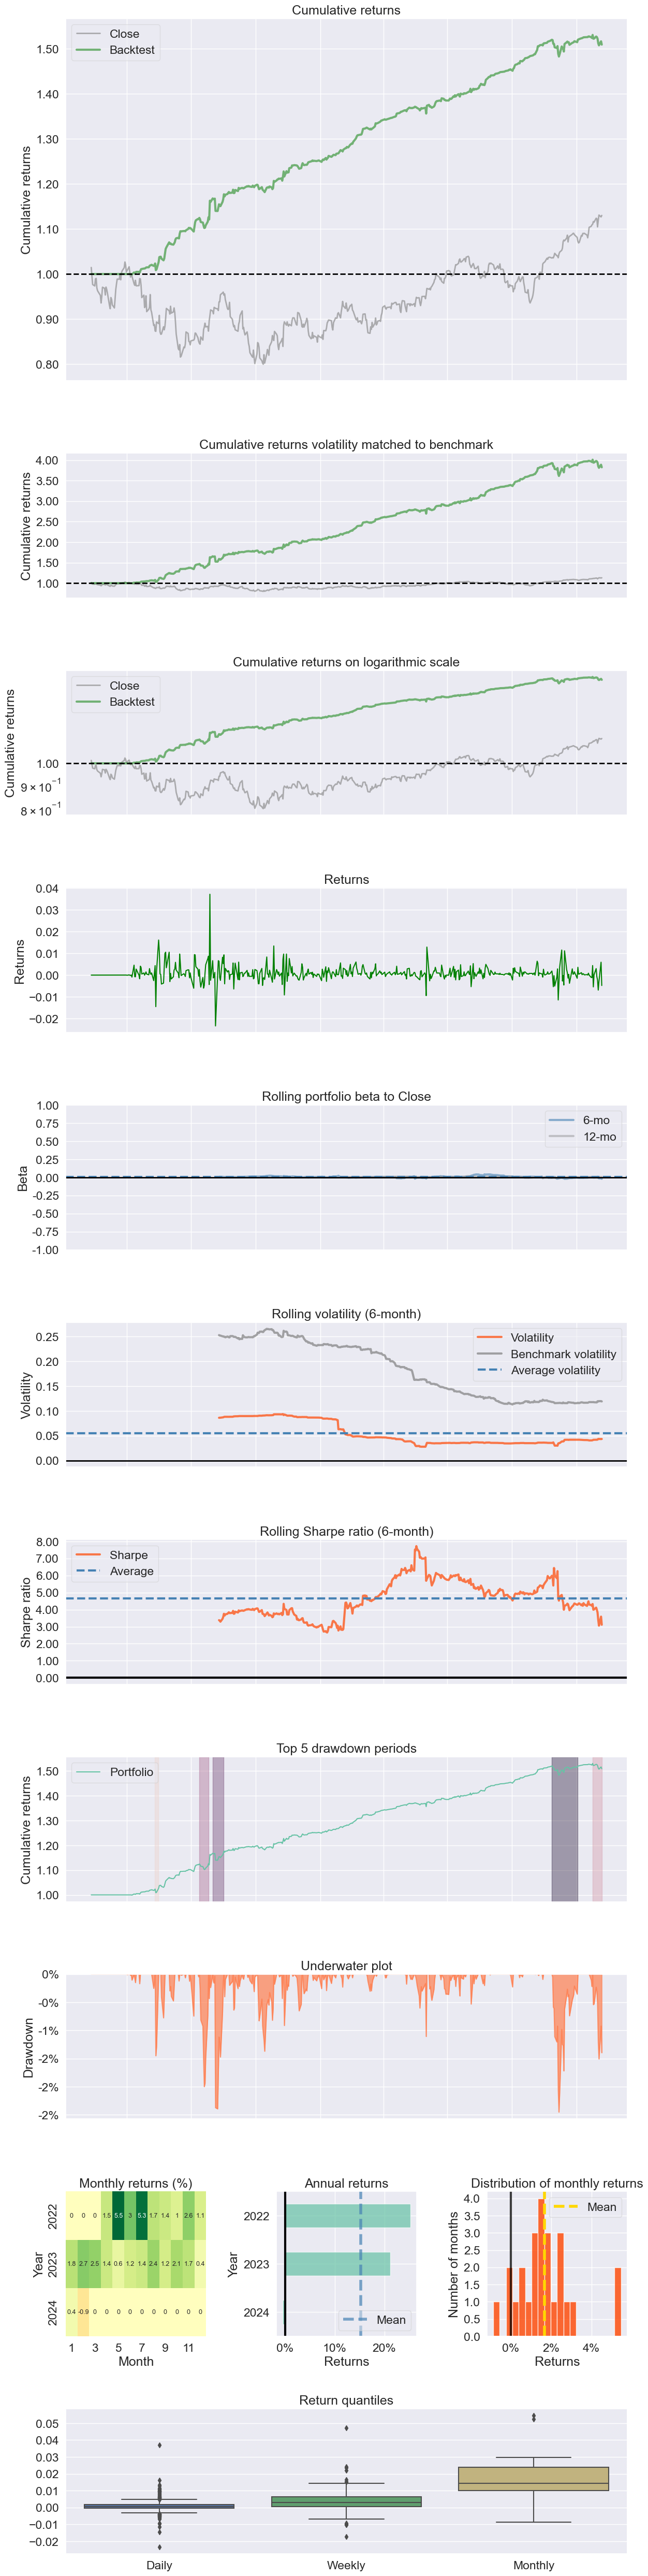

In [16]:
import pyfolio as pf
fig = pf.create_returns_tear_sheet(Pair_Rets.Pairs_Returns, benchmark_rets=bench, return_fig= True)
fig.savefig('porfolio_report/%s'%(end.strftime('%Y_%m_%d')))

In [17]:
Pair_Rets.mean().values[0]

0.000828875902941068

C:\Users\IsaacPC\AppData\Local\Temp\ipykernel_25176\3939018212.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(Pair_Rets, hist = True, kde = True, bins=35,


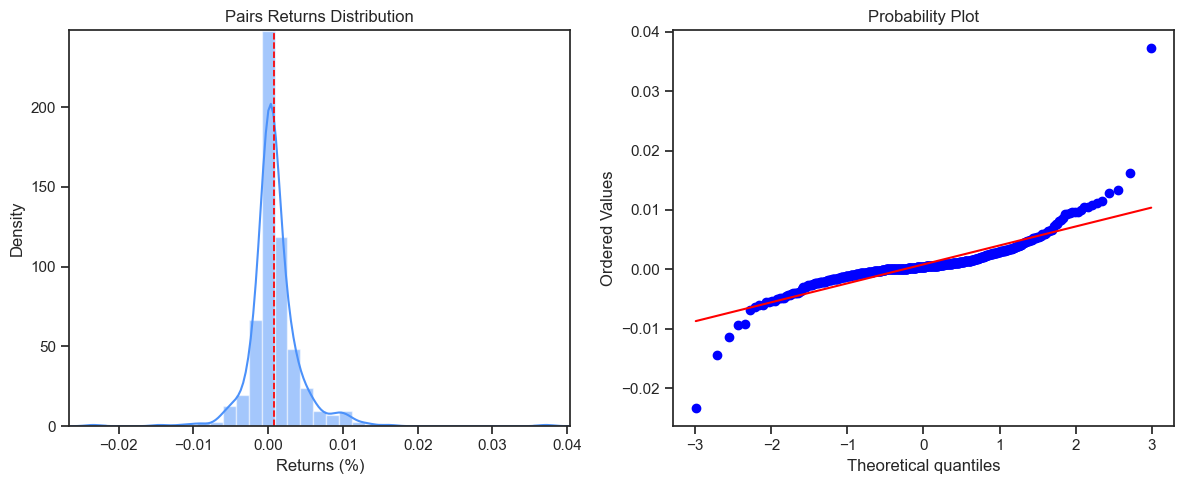

In [18]:
from scipy import stats


fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12, 5))

sns.distplot(Pair_Rets, hist = True, kde = True, bins=35,
                 hist_kws = {'linewidth': 1, 'alpha':.5},
                 label='Pairs Returns', color='#4b91fa', ax=ax1)

ax1.axvline(x=Pair_Rets.mean().values[0], color='#ff0000', linewidth=1.25, linestyle='dashed',label = 'Returns Mean')

ax1.set_title('Pairs Returns Distribution')
ax1.margins(0.001)
ax1.set_xlabel('Returns (%)')
ax1.set_ylabel('Density')

stats.probplot(Pair_Rets.Pairs_Returns, plot=ax2)

plt.tight_layout()

plt.show()

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

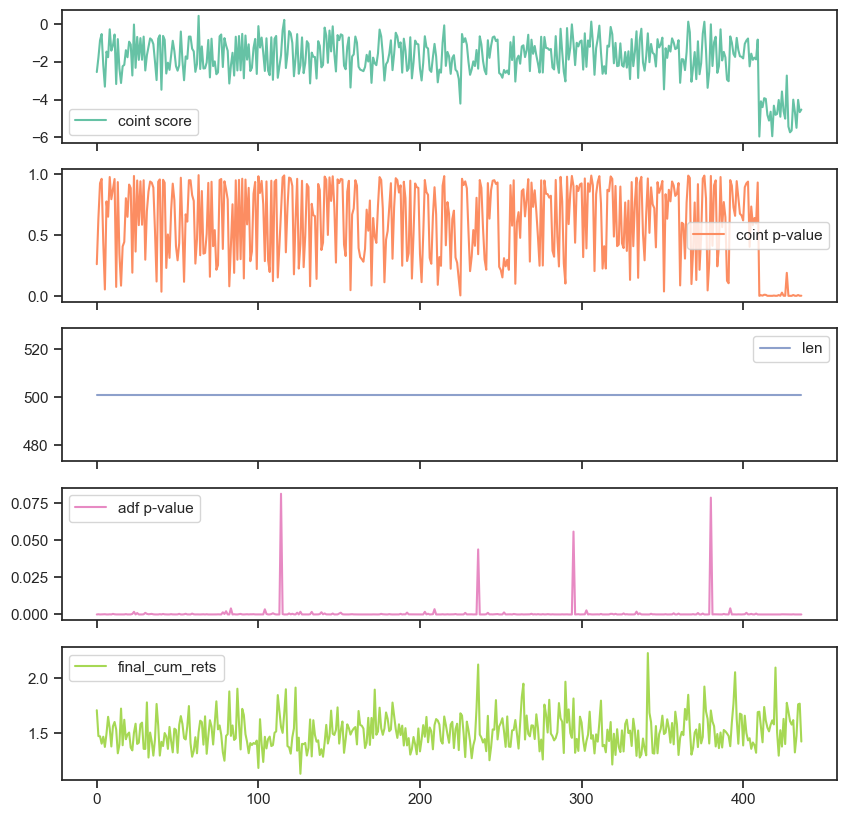

In [19]:
df_pair_score.plot(figsize=(10,10),subplots=True)

Check the distribution of len

C:\Users\IsaacPC\AppData\Local\Temp\ipykernel_25176\4095186782.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_pair_score.len, hist = True, kde = True, bins=35,
h:\anaconda\envs\backtest\lib\site-packages\seaborn\distributions.py:2511: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)


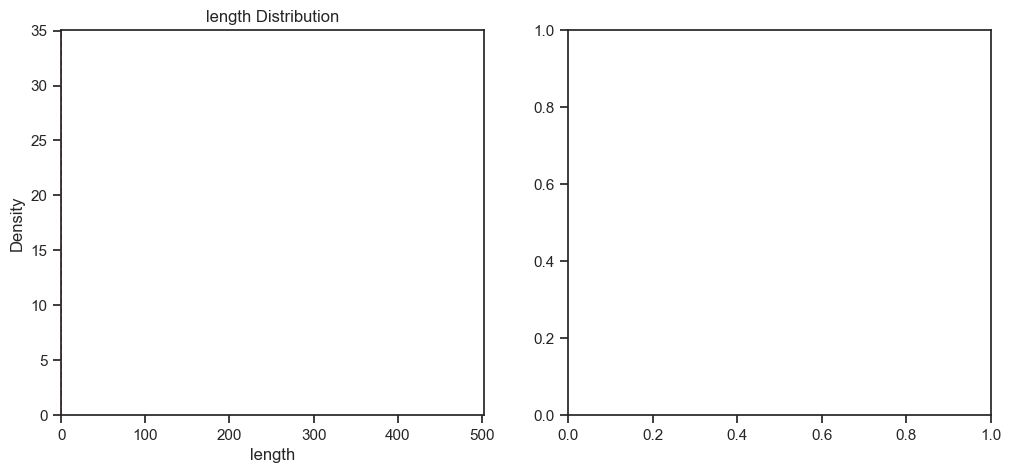

In [20]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12, 5))

sns.distplot(df_pair_score.len, hist = True, kde = True, bins=35,
                 hist_kws = {'linewidth': 1, 'alpha':.5},
                 label='Pairs Returns', color='#4b91fa', ax=ax1)

ax1.axvline(x=Pair_Rets.mean().values[0], color='#ff0000', linewidth=1.25, linestyle='dashed',label = 'Returns Mean')

ax1.set_title('length Distribution')
ax1.margins(0.001)
ax1.set_xlabel('length')
ax1.set_ylabel('Density')

plt.show()

Check correlation

In [21]:
corr = df_pair_score.corr()
corr.style.background_gradient(cmap='coolwarm')


h:\anaconda\envs\backtest\lib\site-packages\pandas\io\formats\style.py:3554: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
h:\anaconda\envs\backtest\lib\site-packages\pandas\io\formats\style.py:3555: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


,coint score,coint p-value,len,adf p-value,final_cum_rets
coint score,1.000000,0.941209,nan,0.065153,-0.092084
coint p-value,0.941209,1.000000,nan,0.057183,-0.078475
len,nan,nan,nan,nan,nan
adf p-value,0.065153,0.057183,nan,1.000000,0.134749
final_cum_rets,-0.092084,-0.078475,nan,0.134749,1.000000


h:\anaconda\envs\backtest\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<Axes: xlabel='adf p-value', ylabel='final_cum_rets'>

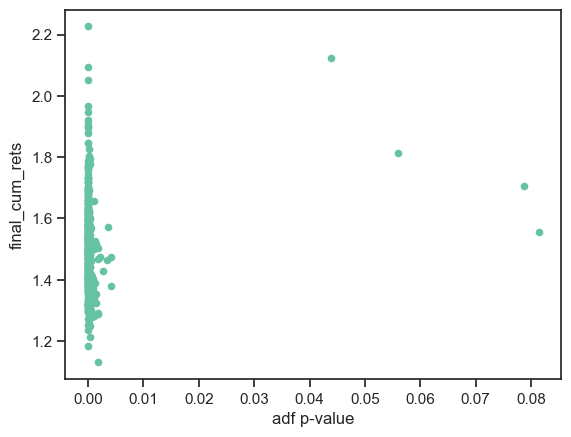

In [22]:
df_pair_score.plot.scatter(x='adf p-value', y='final_cum_rets')

In [23]:
df_pair_score.describe()

,coint score,coint p-value,len,adf p-value,final_cum_rets
count,437.000000,437.000000,437.0,4.370000e+02,437.000000
mean,-1.802062,0.599218,501.0,7.761924e-04,1.509528
std,1.117987,0.325586,0.0,6.376647e-03,0.152762
min,-5.962095,0.000002,501.0,1.761435e-12,1.129832
25%,-2.440053,0.306127,501.0,8.837572e-06,1.400880
50%,-1.712026,0.671388,501.0,3.534426e-05,1.494478
75%,-0.905733,0.919318,501.0,1.213786e-04,1.594291
max,0.436671,0.992193,501.0,8.138228e-02,2.226321


In [24]:
df_pair_score[df_pair_score['final_cum_rets']==1]

,pairs,coint score,coint p-value,len,adf p-value,final_cum_rets,signal


In [25]:
df_pair_score['signal']

0      {nan, 1.0, 0.0, -1.0}
1      {nan, 0.0, -1.0, 1.0}
2      {nan, 0.0, -1.0, 1.0}
3      {nan, 0.0, -1.0, 1.0}
4      {nan, 0.0, -1.0, 1.0}
               ...          
432    {nan, 1.0, 0.0, -1.0}
433    {nan, 0.0, 1.0, -1.0}
434    {nan, 1.0, -1.0, 0.0}
435    {nan, 0.0, 1.0, -1.0}
436    {nan, 0.0, -1.0, 1.0}
Name: signal, Length: 437, dtype: object

h:\anaconda\envs\backtest\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<Axes: xlabel='adf p100', ylabel='final_cum_rets'>

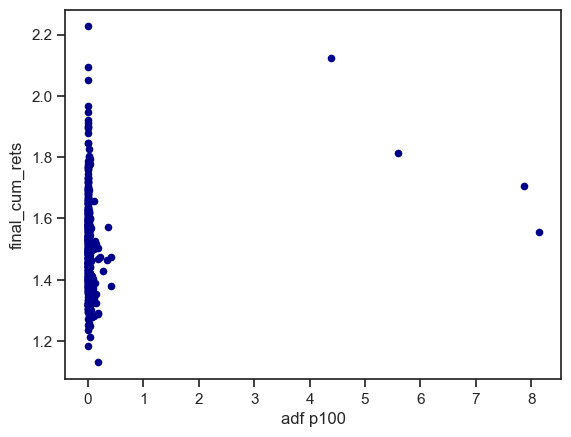

In [26]:
df_pair_score['adf p100'] = df_pair_score['adf p-value']*100
df_pair_score.plot.scatter(x='adf p100',
                      y='final_cum_rets',
                      c='DarkBlue')

In [27]:
df_pair_score['adf p-value']

0      2.493133e-06
1      1.296518e-04
2      3.598827e-06
3      3.182686e-05
4      1.072991e-05
           ...     
432    1.611648e-06
433    1.265823e-07
434    3.668318e-08
435    5.575034e-10
436    1.089548e-06
Name: adf p-value, Length: 437, dtype: float64